In [1]:
# coding=utf-8
from scapy.all import *
import binascii
import struct
import time

import crcmod
import libnum

from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether

import numpy as np

plc_cube = []
hmi_cube = []

def packet_analysis(pkt):
    if TCP in pkt:
        #print(pkt[TCP].dport)
        #print(len(pkt[TCP].payload))
        if len(pkt[TCP].payload) > 6:
            d_time = float(str(pkt.time))
            #print(type(d_time))
            #print(dir(pkt[TCP]))
            #print(pkt.summary())
            #print(pkt.time)
            #print(binascii.hexlify(bytes(pkt[TCP].payload))[12:])
            #print(type(float(pkt.time)))
            if(pkt[TCP].dport == 502):
                #plc_cube.append([d_time,binascii.hexlify(bytes(pkt[TCP].payload))[12:]])
                plc_cube.append(d_time)
            else:
                #hmi_cube.append([d_time,binascii.hexlify(bytes(pkt[TCP].payload))[12:]])
                hmi_cube.append(d_time)


In [2]:
try:
    #print(ifaces)
    #sniff(iface="Realtek PCIe GbE Family Controller", prn=packet_analysis, filter="udp port 18507")
    sniff(offline='DataSet/captures1_v2/captures1_v2/clean/eth2dump-clean-0,5h_1.pcap', prn=packet_analysis, store=0)
    plc_cube = np.asarray(plc_cube)
    hmi_cube = np.asarray(hmi_cube)
    print('Completed')

except Exception as sniff_dec_err:
    traceback.print_exc()
    print(str(sniff_dec_err))

Completed


In [3]:
print(hmi_cube.shape)
print(plc_cube.shape)

(6372,)
(5743,)


In [4]:
print(hmi_cube)

[1.53504605e+09 1.53504605e+09 1.53504605e+09 ... 1.53504785e+09
 1.53504785e+09 1.53504785e+09]


In [5]:
print(plc_cube)

[1.53504605e+09 1.53504605e+09 1.53504605e+09 ... 1.53504785e+09
 1.53504785e+09 1.53504785e+09]


In [6]:
fourier = np.fft.fft(hmi_cube)

In [7]:
timespan = hmi_cube[10] - hmi_cube[0]
print(timespan,'s')

2.810047149658203 s


In [8]:
hmi_diff = np.diff(hmi_cube)

In [9]:
print(hmi_diff)

[0.32065797 0.30996919 0.30929184 ... 0.12016988 0.189188   0.310673  ]


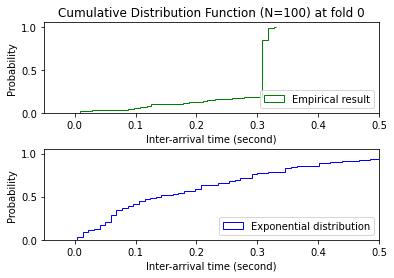

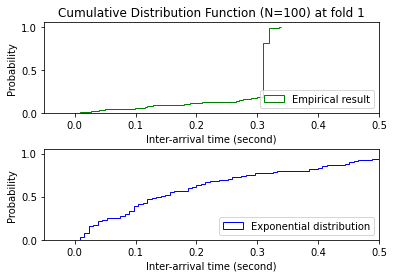

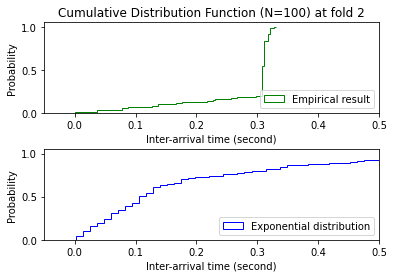

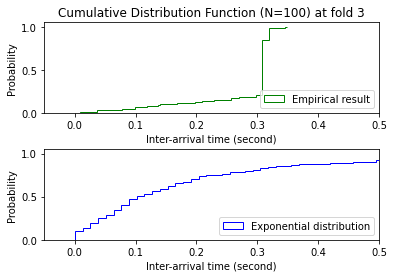

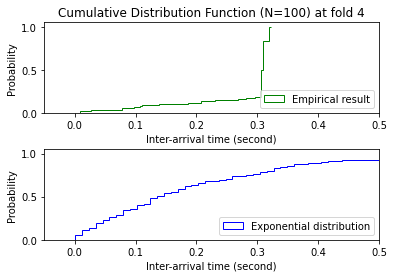

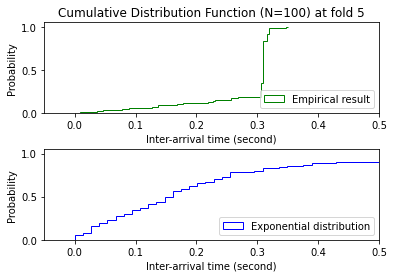

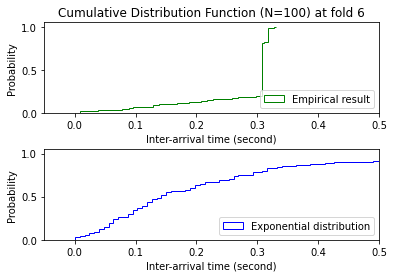

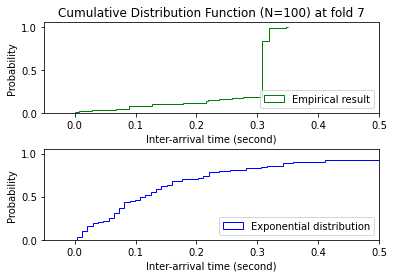

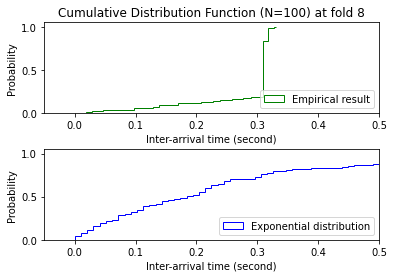

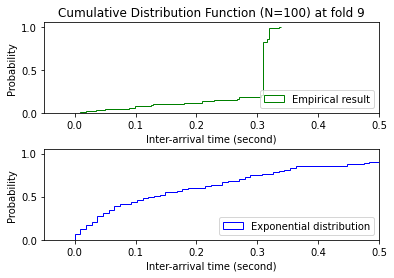

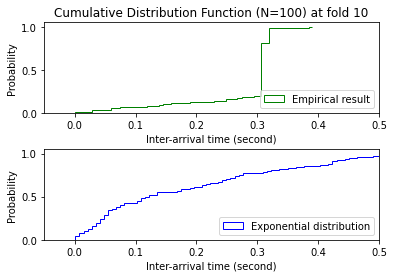

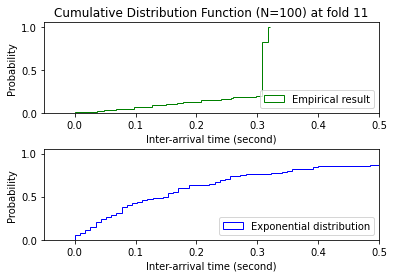

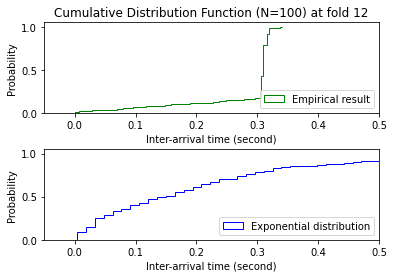

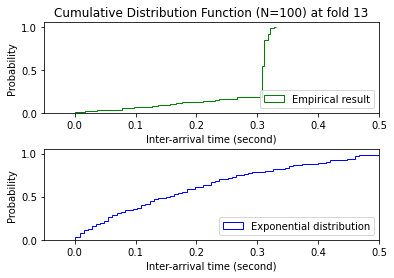

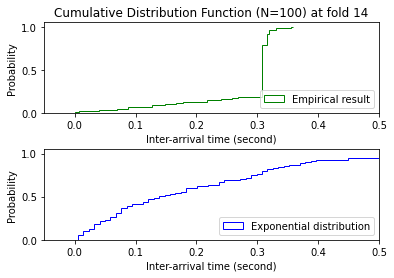

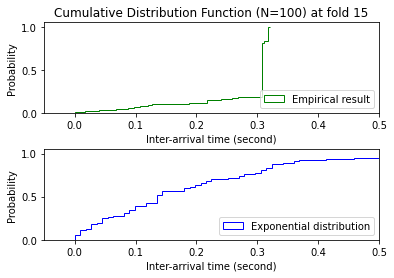

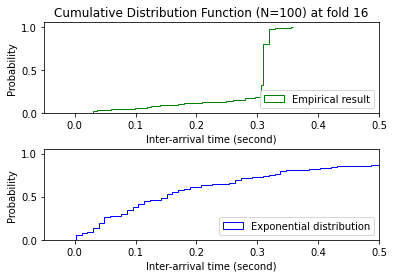

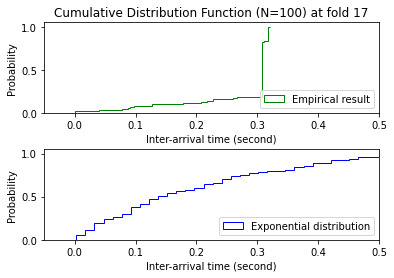

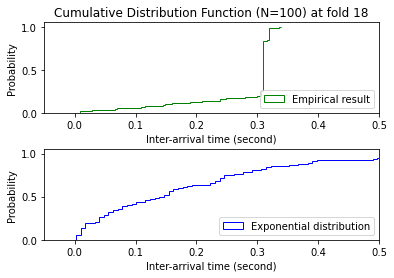

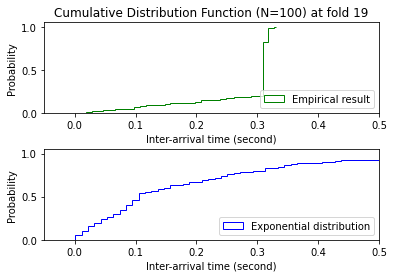

In [10]:

import numpy as np
import matplotlib.pyplot as plt

#fig1, ax = plt.subplots()
for k in range(20):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.subplots_adjust(hspace=0.4)

    #### First, plot the empirical result
    fold = k*100
    y = hmi_diff[fold:fold+100]
    n_bins = len(y)-1
    n, bins, patches = ax1.hist(y, n_bins, density=True, histtype='step',
              cumulative=True, label='Empirical result', color='g')
    # the following line is used to remove the last point
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax1.set_xlim(-0.05, 0.5)
    ax1.set_xlabel('Inter-arrival time (second)')
    ax1.set_ylabel('Probability')
    ax1.set_title('Cumulative Distribution Function (N=100) at fold ' + str(k))
    ax1.legend(loc=4)

    #### Then plot the theoretical expontential distribution
    G = np.random.default_rng()
    y = G.exponential(scale=0.2, size=len(y))
    # Now, plot the cumulative distributioin function (CDF)
    n_bins = len(y)-1
    n, bins, patches = ax2.hist(y, n_bins, density=True, histtype='step',
              cumulative=True, label='Exponential distribution', color='b')
    # the following line is used to remove the last point
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax2.set_xlim(-0.05, 0.5)
    ax2.set_xlabel('Inter-arrival time (second)')
    ax2.set_ylabel('Probability')
    #ax2.set_title('Cumulative Distribution Function (N=100)')
    ax2.legend(loc=4)

plt.show()
#plt.savefig('./cdf.pdf')

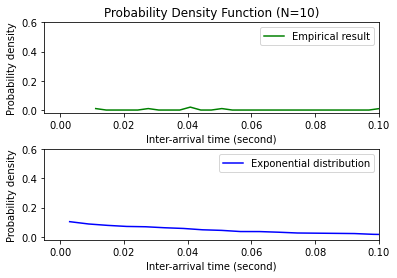

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.4)

#### First, plot the p.d.f. of our empirical result
y = hmi_diff[100:200]
heights, bins = np.histogram(y, bins=100)
# do normalization
heights = heights/float(sum(heights))
binMids = bins[:-1]+np.diff(bins)/2.
ax1.plot(binMids, heights, label='Empirical result', color='g')
ax1.set_xlim(-0.005, 0.1)
ax1.set_ylim(-0.02, 0.6)
ax1.set_xlabel('Inter-arrival time (second)')
ax1.set_ylabel('Probability density')
ax1.set_title('Probability Density Function (N=10)')
ax1.legend(loc=1)

#### Now, plot the p.d.f. of exponential distribution
G = np.random.default_rng()
y = G.exponential(scale=0.055, size=9010)
heights, bins = np.histogram(y, bins=100)
# do normalization
heights = heights/float(sum(heights))
binMids = bins[:-1]+np.diff(bins)/2.
ax2.plot(binMids, heights, label='Exponential distribution', color='b')
ax2.set_xlim(-0.005, 0.1)
ax2.set_ylim(-0.02, 0.6)
ax2.set_xlabel('Inter-arrival time (second)')
ax2.set_ylabel('Probability density')
ax2.legend(loc=1)

plt.show()


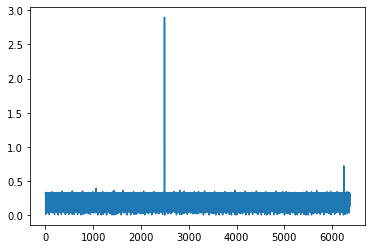

In [12]:
plt.plot(hmi_diff)
plt.show()

In [13]:
freqs = np.fft.fftfreq(len(hmi_diff))

In [14]:
for coef,freq in zip(fourier,freqs):
    if coef:
        print('{c:>6} * exp(2 pi i t * {f})'.format(c=coef,f=freq))

(9781319153432.705+0j) * exp(2 pi i t * 0.0)
(-2050.3945881177806+1825697.2366937706j) * exp(2 pi i t * 0.0001569612305760477)
(31.198464451215614+912084.554855567j) * exp(2 pi i t * 0.0003139224611520954)
(-1329.1696177304475+607951.9769292128j) * exp(2 pi i t * 0.00047088369172814315)
(-657.4230147635859+456503.4804703325j) * exp(2 pi i t * 0.0006278449223041908)
(-765.5436983076985+364555.68498138187j) * exp(2 pi i t * 0.0007848061528802385)
(-1077.5835495660253+304234.53270780435j) * exp(2 pi i t * 0.0009417673834562863)
(-583.1621391210327+260722.65421744072j) * exp(2 pi i t * 0.0010987286140323339)
(-966.3867641294422+227914.10163926097j) * exp(2 pi i t * 0.0012556898446083817)
(-843.2064772566351+202936.38913753894j) * exp(2 pi i t * 0.0014126510751844294)
(-753.3532477684458+182367.44450055092j) * exp(2 pi i t * 0.001569612305760477)
(-974.9352513357187+165951.13639565645j) * exp(2 pi i t * 0.0017265735363365248)
(-720.9742237632446+152142.02224677478j) * exp(2 pi i t * 0.00188

(-899.585941539435+833.9330222768656j) * exp(2 pi i t * 0.26259613875372784)
(-898.1053329421727+828.6144541388555j) * exp(2 pi i t * 0.26275309998430385)
(-901.7582991968806+829.8387453418495j) * exp(2 pi i t * 0.2629100612148799)
(-898.0573640667518+830.0782028161435j) * exp(2 pi i t * 0.26306702244545593)
(-900.5660788381302+825.5928168891195j) * exp(2 pi i t * 0.263223983676032)
(-900.0979519809858+829.3407086894716j) * exp(2 pi i t * 0.26338094490660807)
(-898.0793220315724+824.9669103296064j) * exp(2 pi i t * 0.2635379061371841)
(-901.8998430138123+826.2692007120595j) * exp(2 pi i t * 0.26369486736776016)
(-898.4266666818587+826.5139805526582j) * exp(2 pi i t * 0.26385182859833617)
(-900.0183296056761+821.6327837956968j) * exp(2 pi i t * 0.26400878982891224)
(-901.3828884407428+825.0726841256267j) * exp(2 pi i t * 0.2641657510594883)
(-897.1148867607535+821.9534902684327j) * exp(2 pi i t * 0.2643227122900643)
(-902.8344138736368+820.3234232818011j) * exp(2 pi i t * 0.264479673520

(-900.064658358736+89.80283850376459j) * exp(2 pi i t * 0.4683723120389264)
(-898.5040812767097+90.08990857858956j) * exp(2 pi i t * 0.4685292732695024)
(-899.627035712971+88.60739469612537j) * exp(2 pi i t * 0.46868623450007846)
(-899.9553475500342+89.36802407926565j) * exp(2 pi i t * 0.46884319573065447)
(-898.8031849587295+88.10094505471274j) * exp(2 pi i t * 0.46900015696123054)
(-900.313617394793+87.72742146979765j) * exp(2 pi i t * 0.4691571181918066)
(-899.0962916539439+87.99595493717459j) * exp(2 pi i t * 0.4693140794223826)
(-899.8683094725902+86.57974548333829j) * exp(2 pi i t * 0.4694710406529587)
(-900.2499471924689+87.36712374718968j) * exp(2 pi i t * 0.46962800188353476)
(-899.4426064426826+86.38801229392746j) * exp(2 pi i t * 0.4697849631141108)
(-900.7239019506195+85.90601143722743j) * exp(2 pi i t * 0.46994192434468685)
(-899.2905393216004+86.11572949174422j) * exp(2 pi i t * 0.47009888557526286)
(-899.7217279960859+84.44579255689187j) * exp(2 pi i t * 0.47025584680583

(-901.3640640179987-579.5156462643691j) * exp(2 pi i t * -0.31768953068592054)
(-899.0307841519318-579.0517299523402j) * exp(2 pi i t * -0.3175325694553445)
(-900.4774924659972-580.8096753475844j) * exp(2 pi i t * -0.31737560822476846)
(-900.7534802342665-580.035119195351j) * exp(2 pi i t * -0.3172186469941924)
(-899.2152843626386-583.2313658772414j) * exp(2 pi i t * -0.3170616857636164)
(-902.4393348441687-581.7658501430199j) * exp(2 pi i t * -0.3169047245330403)
(-899.1077005517704-581.3978720376734j) * exp(2 pi i t * -0.3167477633024643)
(-900.1881921791384-585.9309510825748j) * exp(2 pi i t * -0.3165908020718882)
(-900.347171603601-583.795813013536j) * exp(2 pi i t * -0.31643384084131215)
(-899.3563038854494-586.5084967360362j) * exp(2 pi i t * -0.31627687961073614)
(-901.4445560921134-585.408823951836j) * exp(2 pi i t * -0.31611991838016007)
(-899.4674106408015-585.2944808398576j) * exp(2 pi i t * -0.31596295714958406)
(-899.7448171729411-588.6877938695145j) * exp(2 pi i t * -0.31

(-903.5111286634472-1973.1535423443631j) * exp(2 pi i t * -0.13592842567885732)
(-894.9240641552859-1977.1631723184998j) * exp(2 pi i t * -0.13577146444828125)
(-902.6346851397433-1982.9361646412465j) * exp(2 pi i t * -0.1356145032177052)
(-898.9231567382812-1978.1680803807856j) * exp(2 pi i t * -0.13545754198712917)
(-896.6129615351452-1988.5395848841918j) * exp(2 pi i t * -0.13530058075655313)
(-904.4618834015076-1986.5979395239256j) * exp(2 pi i t * -0.1351436195259771)
(-895.5534269746-1988.2257251180183j) * exp(2 pi i t * -0.13498665829540102)
(-901.8674124695315-1997.0747236287898j) * exp(2 pi i t * -0.13482969706482498)
(-901.3593162982181-1991.187503436891j) * exp(2 pi i t * -0.13467273583424894)
(-895.7830117765905-2000.7246865750235j) * exp(2 pi i t * -0.1345157746036729)
(-904.4753622219268-2001.239090268278j) * exp(2 pi i t * -0.13435881337309682)
(-896.5803861417797-2000.510177194708j) * exp(2 pi i t * -0.13420185214252078)
(-900.9071907323834-2010.9399181117021j) * exp(2 